---------------->THIS IS THE PIPELINE

#importing

In [ ]:
import os
import warnings
import datetime
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

from tensorflow import keras
from keras import layers
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import AUC, Precision, Recall

from sklearn.utils.class_weight import compute_class_weight

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


#Feature encoding 

1957-10-04 09:28:00


C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\4008516533.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 14  4 ... 18 18 18]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[:, col] = LabelEncoder().fit_transform(data[col])
C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\4008516533.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 30 44 ...  5  5  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[:, col] = LabelEncoder().fit_transform(data[col])
C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\4008516533.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 68 68 68]' has dtype incompatible with int32, please explicitly cas

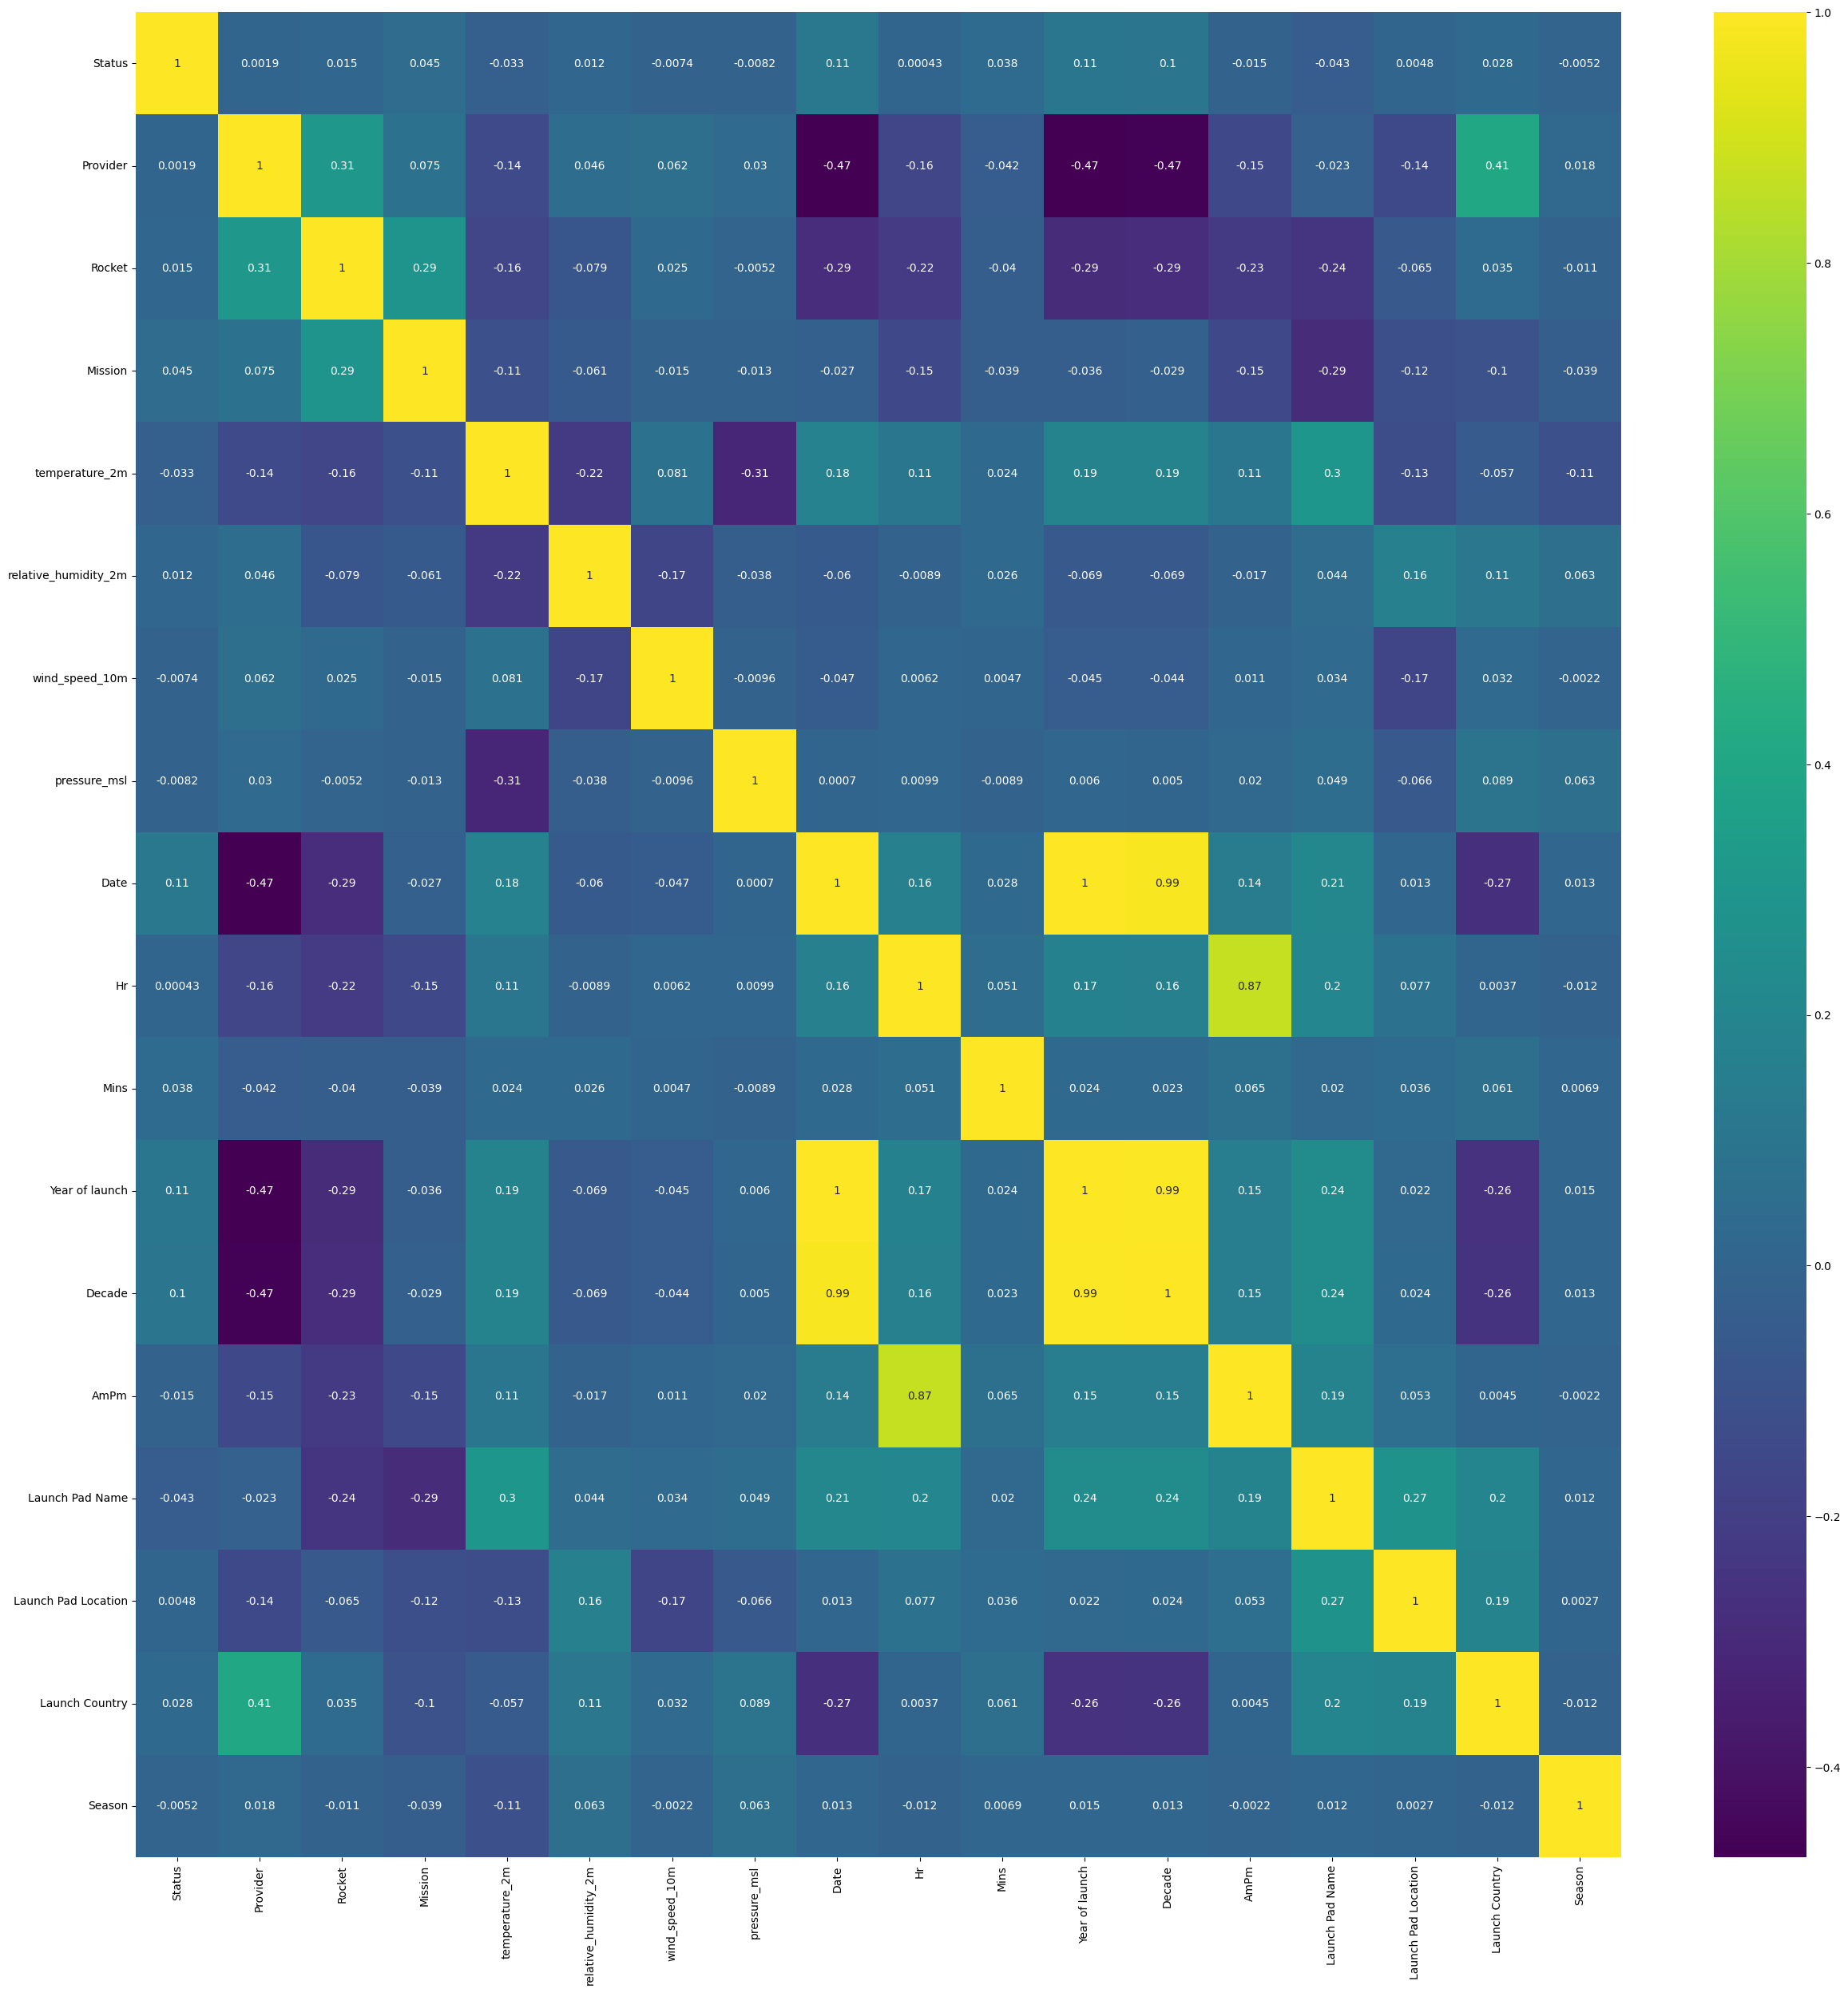

6838


In [ ]:
data=pd.read_excel("final_edited.xlsx")
# str(data['Date (Central Time)'][0].time())
data=pd.read_excel("final_edited.xlsx")
mask = data["Mission"] == "—"
data.loc[mask, "Mission"] = data.loc[mask, "Name"].apply(lambda x: str(x).split("|")[1].lstrip())
data.drop(columns=['Name'],inplace=True) 
print( data['Date (Central Time)'][0])
data['Date (Central Time)'] = pd.to_datetime(data['Date (Central Time)'], errors='coerce')
data['Date'] = data['Date (Central Time)'].dt.date
data['Time'] = data['Date (Central Time)'].dt.time
data['Hr'] = data['Date (Central Time)'].dt.hour
data['Mins'] = data['Date (Central Time)'].dt.minute
data['Month'] = data['Date (Central Time)'].dt.month
data['Year of launch']=data['Date (Central Time)'].dt.year
data["Decade"] = (data["Year of launch"] // 10 * 10).astype(str) + "s"
def ampm(x):
    if int(x)>12:
        return "PM"
    else: return "AM"

data["AmPm"]=data['Hr'].apply(ampm)
data.drop(columns=['Date (Central Time)'],inplace=True)
data[["Launch Pad Name","Launch Pad Location"]]=data['Launch Pad'].str.split("|",expand=True)
data.drop(columns=['Launch Pad'],inplace=True)

data=data[data["Status"] != "Go for Launch"]
data['Status']=data['Status'].replace("Launch was a Partial Failure","Launch Failure")
data['Launch Country'] = data['Launch Pad Location'].str.split(",").str[-1].str.strip()
data = data[data["Provider"] != "Unknown"]
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

data['Season'] = data['Month'].apply(get_season)

data.drop(columns=['Month'], inplace=True)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
columns_to_keep = [
    'Status', 'Provider', 'Rocket', 'Mission', 'temperature_2m',
    'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl', 'Date', 'Hr', 'Mins', 'Year of launch', 'Decade',
    'AmPm', 'Launch Pad Name', 'Launch Pad Location', 'Launch Country',
    'Season'
]

data = data[columns_to_keep]
types={
  "Strategic Rocket Forces": "Satellite launches (Military)",
  "Arianespace": "Commercial satellite launches, commercial missions",
"Soviet Space Program": "Scientific research, satellite launches, military applications",
  "China Aerospace Science and Technology Corporation": "Satellite launches, space research (scientific)",
  "General Dynamics": "Satellite launches, military applications",
  "Army Ballistic Missile Agency": "Military applications, satellite launches, scientific research",
  "National Aeronautics and Space Administration": "Scientific research, space station operations",
  "Russian Aerospace Defence Forces": "Military applications, intelligence",
  "United States Air Force": "Military applications, space research",
  "United Launch Alliance": "Commercial satellite launches, military missions",
  "Boeing": "Commercial satellite launches, space research",
  "Martin Marietta": "Commercial satellite launches, space research",
  "SpaceX": "Commercial satellite launches, manned space missions",
  "Mitsubishi Heavy Industries": "Commercial satellite launches",
  "Northrop Grumman Space Systems": "Military applications, space research",
  "Lockheed Martin": "Military applications, space research",
  "Indian Space Research Organization": "Scientific research, satellite launches",
  "Russian Federal Space Agency (ROSCOSMOS)": "Scientific research, space station operations",
  "International Launch Services": "Commercial satellite launches, commercial missions",
  "Sea Launch": "Commercial satellite launches",
  "Institute of Space and Astronautical Science": "Scientific research, space research",
  "ISC Kosmotras": "Commercial satellite launches",
  "US Navy": "Military applications, satellite launches",
  "US Army":"Military applications, satellite launches",
  "Israeli Space Agency": "Scientific research, space research",
  "Rocket Lab": "Commercial satellite launches",
  "Eurockot Launch Services": "Commercial satellite launches",
  "European Space Agency": "Scientific research, space research",
  "Blue Origin": "Commercial satellite launches, manned space missions",
  "Israel Aerospace Industries": "Commercial satellite launches, military applications",
  "ExPace": "Commercial satellite launches",
  "Italian Space Agency": "Scientific research, space research",
  "National Center of Space Research": "Scientific research, space research",
  "Mitsubishi (AMBA/MITT proxy)": "Commercial satellite launches",
  "Japan Aerospace Exploration Agency": "Scientific research, space research",
  "LandSpace": "Commercial satellite launches",
  "Korea Aerospace Research Institute": "Scientific research, space research",
  "China Aerospace Science and Industry Corporation": "Commercial satellite launches, military applications",
  "EXOS Aerospace": "Commercial satellite launches",
  "Armee de l'Air": "Military applications, satellite launches",
  "Brazilian Space Agency": "Scientific research, space research",
  "OKB-586": "Commercial satellite launches, military applications",
  "Yuzhmash": "Commercial satellite launches, space research",
  "Douglas": "Commercial satellite launches",
    "Science and Engineering Research Council": "Scientific research, space research",
  "National Research Council": "Scientific research, space research",
  "Weapons Research Establishment": "Military applications, space research",
  "European Space Research Organisation": "Scientific research, space research",
  "European Launcher Development Organisation": "Commercial satellite launches, space research",
  "Starsem SA": "Commercial satellite launches",
  "Virgin Orbit": "Commercial satellite launches",
  "Islamic Revolutionary Guard Corps Aerospace Force": "Military applications, space research",
  "iSpace": "Commercial satellite launches",
  "OneSpace": "Commercial satellite launches",
   "Convair": "Commercial satellite launches, military applications",
  "Rockwell International": "Commercial satellite launches, space research",
  "Ministry of Space Industry": "Military applications, satellite launches",
  "Lockheed Space Operations Company": "Military applications, space research",
  "Ministry of Aerospace Industry": "Military applications, satellite launches",
  "Orbital Sciences Corporation": "Commercial satellite launches, space research",
  "Russian Space Forces": "Military applications, intelligence",
  "Progress Rocket Space Center": "Commercial satellite launches, space research",
  "Production Corporation Polyot": "Commercial satellite launches",
  "China Aerospace Corporation": "Commercial satellite launches, space research",
  "Lockheed Martin Space Operations": "Military applications, space research",
  "Space Services Inc.": "Commercial satellite launches",
  "United Space Alliance": "Commercial satellite launches, space research",
  "Makeyev Rocket Design Bureau": "Military applications, satellite launches",
  "Korean Committee of Space Technology": "Scientific research, space research",
  "Iranian Space Agency": "Scientific research, space research",
  "Virgin Galactic": "Commercial satellite launches, manned space missions",
  "Antrix Corporation Limited": "Commercial satellite launches",
  "National Aerospace Development Administration": "Military applications, space research",
  "Orbital ATK": "Commercial satellite launches, military applications",
  "Interstellar Technologies": "Commercial satellite launches",
  "China Rocket Co. Ltd.": "Commercial satellite launches",
  "Astra Space": "Commercial satellite launches",
  "Galactic Energy": "Commercial satellite launches",
  "GK Launch Services": "Commercial satellite launches",
  "Firefly Aerospace": "Commercial satellite launches",
  "TiSPACE": "Commercial satellite launches",
  "Equatorial Launch Australia": "Commercial satellite launches",
  "ABL Space Systems": "Commercial satellite launches",
  "Relativity Space": "Commercial satellite launches",
  "Space Pioneer": "Commercial satellite launches",
  "CAS Space": "Commercial satellite launches",
  "Payload Aerospace S.L.": "Commercial satellite launches",
  "Agency for Defense Development": "Military applications, space research",
  "Orienspace Technology": "Commercial satellite launches",
  "Space One": "Commercial satellite launches",
  "HyImpulse": "Commercial satellite launches",
  "Isar Aerospace": "Commercial satellite launches",
  "Rocket Factory Augsburg": "Commercial satellite launches",
  "Orbex": "Commercial satellite launches",
  "Skyrora": "Commercial satellite launches",
    "German Aerospace Center": "Scientific research, space research",
  "Seventh Ministry of Machine Building Industry": "Military applications, satellite launches",
  "Royal Aircraft Establishment": "Scientific research, military applications",
  "National Space Development Agency of Japan": "Scientific research, satellite launches",
  "Sandia National Laboratories": "Scientific research, military applications",
  "Khrunichev State Research and Production Space Center": "Commercial satellite launches, military applications"
}
groups = {
    "Commercial Satellite Launches": [
        "Commercial satellite launches",
        "Commercial satellite launches, military applications",
        "Commercial satellite launches, space research",
        "Commercial satellite launches, commercial missions",
        "Commercial satellite launches, manned space missions",
        "Commercial satellite launches, military missions"
    ],
    "Scientific Research": [
        "Scientific research, space research",
        "Scientific research, space station operations",
        "Scientific research, satellite launches",
        "Satellite launches, space research (scientific)",
        "Scientific research, military applications"
    ],
    "Military and Other Missions": [
        "Military applications, space research",
        "Military applications, satellite launches",
        "Satellite launches (Military)",
        "Satellite launches, military applications",
        "Military applications, intelligence"
    ]
}
data['Companey Type']=data["Provider"].apply(lambda x : types[x])

def match_group(description):
    if pd.isna(description):
        return None
    for group, keywords in groups.items():
        for keyword in keywords:
            if keyword in description:
                return group
    return None

data['Companey Group']=data['Companey Type'].apply(match_group)
data=data.sort_values(by="Date")
data_training=data[data["Status"].isin(data['Status'].unique()[:2])] 
data_forcasting=data[data["Status"].isin(data['Status'].unique()[2:])]
data=data_training[['Status', 'Provider', 'Rocket', 'Mission', 'temperature_2m',
    'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl', 'Date', 'Hr', 'Mins', 'Year of launch', 'Decade',
    'AmPm', 'Launch Pad Name', 'Launch Pad Location', 'Launch Country',
    'Season']]

for col in data:
    data.loc[:, col] = LabelEncoder().fit_transform(data[col])
plt.figure(figsize=(30, 30)) 
sns.heatmap(data.corr(),cmap='viridis', annot=True)
plt.show()
print(len(data_training))
# data.to_excel('data_pipeline_output.xlsx')   


#Using Free Open-Metro api to get the climate at that particular time and place by fetching the coordinates form the launch station using geopy library

In [3]:
# import requests
# import pandas as pd
# from time import sleep
# from geopy.geocoders import Nominatim
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from datetime import datetime
# from tqdm import tqdm
# import os

# # ---------------- CONFIG ---------------- #
# chunk_size = 100
# batch_tracker_file = "last_batch.txt"
# geo_cache = {}
# count=0
# # ---------------- GEOLOCATION ---------------- #
# def safe_geocode(location_str, retries=3):
#     geolocator = Nominatim(user_agent="launch_locator")
#     for i in range(retries):
#         try:
#             location = geolocator.geocode(location_str, timeout=10)
#             if location:
#                 return location.latitude, location.longitude
#         except Exception:
#             print(f"Geocoding retry {i+1} for '{location_str}'... sleeping {2**i} sec")
#             sleep(3)
#     return None, None

# def clean_location(loc):
#     parts = loc.split("|")
#     return parts[-1].strip() if len(parts) > 1 else loc.strip()

# def get_coordinates(location_str):
#     full_key = location_str.strip()
#     fallback_key = clean_location(location_str)

#     if full_key in geo_cache:
#         return geo_cache[full_key]

#     latlon = safe_geocode(full_key)
#     if latlon and latlon != (None, None):
#         geo_cache[full_key] = latlon
#         return latlon

#     if fallback_key in geo_cache:
#         print(f"Using cached fallback for: '{fallback_key}'")
#         return geo_cache[fallback_key]

#     print(f" Fallback geocoding for: '{fallback_key}'")
#     latlon = safe_geocode(fallback_key)
#     geo_cache[fallback_key] = latlon
#     if not latlon or latlon == (None, None):
#         print(f" Geocoding failed for both: '{full_key}' and fallback: '{fallback_key}'")
#     return latlon

# # ---------------- WEATHER FETCH ---------------- #
# def weatherdata(loc, date, index=None):
#     try:
#         latitude, longitude = get_coordinates(loc)
#         if not latitude or not longitude:
#             print(f"[{index}]  Geolocation failed for: {loc}")
#             return {
#                 'temperature_2m': None, 'relative_humidity_2m': None,
#                 'wind_speed_10m': None, 'pressure_msl': None,
#                 'latitude': None, 'longitude': None
#             }

#         url = (
#             f"https://archive-api.open-meteo.com/v1/archive?"
#             f"latitude={latitude}&longitude={longitude}"
#             f"&start_date={date}&end_date={date}"
#             f"&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl"
#         )

#         sleep(1)
#         response = requests.get(url)
#         response.raise_for_status()
#         w_data = response.json()

#         if "hourly" not in w_data:
#             print(f"[{index}]  No hourly data for {loc} on {date}")
#             return {
#                 'temperature_2m': None, 'relative_humidity_2m': None,
#                 'wind_speed_10m': None, 'pressure_msl': None,
#                 'latitude': latitude, 'longitude': longitude
#             }

#         df = pd.DataFrame(w_data["hourly"])
#         avg_values = df[["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "pressure_msl"]].mean()

#         metrics = dict(avg_values)
#         metrics['latitude'] = latitude
#         metrics['longitude'] = longitude

#         print(f"[{index}]  Weather fetched for {loc} on {date}")
#         return metrics

#     except Exception as e:
#         print(f"[{index}]  Error for {loc} on {date}: {e}")
#         return {
#             'temperature_2m': None, 'relative_humidity_2m': None,
#             'wind_speed_10m': None, 'pressure_msl': None,
#             'latitude': None, 'longitude': None
#         }

# # ---------------- BATCHED MULTITHREADING ---------------- #
# def fetch_weather_row(index, row):
#     try:
#         loc = row['Launch Pad']
#         date = pd.to_datetime(row['Date (Central Time)']).date().isoformat()
#         return weatherdata(loc, date, index)
#     except Exception as e:
#         print(f"[{index}]  Row processing failed: {e}")
#         return {
#             'temperature_2m': None, 'relative_humidity_2m': None,
#             'wind_speed_10m': None, 'pressure_msl': None,
#             'latitude': None, 'longitude': None
#         }

# def chunk_dataframe(df, chunk_size):
#     for i in range(0, len(df), chunk_size):
#         yield df.iloc[i:i + chunk_size], i

# # ---------------- BATCH TRACKING ---------------- #
# def get_last_batch_id():
#     if os.path.exists(batch_tracker_file):
#         try:
#             with open(batch_tracker_file, "r") as f:
#                 return int(f.read().strip())
#         except:
#             return 0
#     return 0

# def update_last_batch_id(batch_id):
#     with open(batch_tracker_file, "w") as f:
#         f.write(str(batch_id))

# # ---------------- MAIN EXECUTION ---------------- #
# data = pd.read_excel("/content/space_launches_advanced_report.xlsx")
# trials = data[~data["Status"].isin(['To Be Determined', 'To Be Confirmed'])]

# weather_rows = []
# last_batch_id = get_last_batch_id()

# for batch, start_idx in tqdm(chunk_dataframe(trials, chunk_size=chunk_size), desc="Processing batches"):
#     batch_id = start_idx // chunk_size + 1
#     if batch_id <= last_batch_id:
#         print(f"Skipping batch {batch_id} (already saved)")
#         continue

#     weather_rows_batch = []
#     with ThreadPoolExecutor(max_workers=1) as executor:
#         futures = {
#             executor.submit(fetch_weather_row, start_idx + i, row): start_idx + i
#             for i, (_, row) in enumerate(batch.iterrows())
#         }
#         for future in as_completed(futures):
#             result = future.result()
#             count+=1
#             print(count,str(result))
#             weather_rows_batch.append(result)
#             weather_rows.append(result)

#     batch_df = pd.DataFrame(weather_rows_batch)
#     merged_batch = pd.concat([batch.reset_index(drop=True), batch_df], axis=1)
#     batch_output = f"enriched_batch_{batch_id}.xlsx"
#     merged_batch.to_excel(batch_output, index=False)
#     update_last_batch_id(batch_id)
#     count=0
#     print(f" Saved enriched batch {batch_id} to {batch_output}")

# # ---------------- FINAL MERGE AND EXPORT ---------------- #
# weather_df = pd.DataFrame(weather_rows)
# trials = pd.concat([trials.reset_index(drop=True), weather_df], axis=1)

# timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# output_path = f"/content/enriched_launch_data_{timestamp}.xlsx"
# trials.to_excel(output_path, index=False)
# print(f"\Final export complete: {output_path}")


Above code give the output of latitude, longitude and the climate metrics like pressure,temparature,humidity,windspeed in batches since there are more than 5000 records, this code returns the output in batched of chunk size 100rows

In [4]:
# os.chdir("C:\\Users\\Nagasheshu\\Desktop\\Minor project\\Datasets\\Weather\\with weather")#this path contains all batches each of 100rows
# datasets=[]
# for i in os.listdir():
#     data=pd.read_excel(i)
#     datasets.append(data)
# with_weather=pd.concat(datasets,axis=0)
# with_weather['Date (Central Time)'] = pd.to_datetime(with_weather['Date (Central Time)'], errors='coerce')
# with_weather = with_weather.sort_values(by='Date (Central Time)').reset_index(drop=True)
# with_weather.to_excel("data_pipeline_output.xlsx", index=False)

Above code concats all batches into 1 excel file 

------------>Testing all models

#Loading the Exceloutput from pipeline

In [5]:
data=pd.read_excel("data_pipeline_output.xlsx")
data.drop(columns=['Unnamed: 0'],inplace=True) 
data=data.sort_values(by="Date")
data_training=data[data["Status"].isin(data['Status'].unique()[:2])] 
data_forcasting=data[data["Status"].isin(data['Status'].unique()[2:])]
encoded_data=data_training[['Status', 'Provider', 'Rocket', 'Mission', 'temperature_2m',
    'relative_humidity_2m', 'wind_speed_10m', 'pressure_msl', 'Date', 'Hr', 'Mins', 'Year of launch', 'Decade',
    'AmPm', 'Launch Pad Name', 'Launch Pad Location', 'Launch Country',
    'Season']]

for col in encoded_data:
    encoded_data.loc[:, col] = LabelEncoder().fit_transform(encoded_data[col])

C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\1021764206.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[   0    1    2 ... 5763 5764 5764]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  encoded_data.loc[:, col] = LabelEncoder().fit_transform(encoded_data[col])


#Scalling

In [6]:
categorical_cols = encoded_data.select_dtypes(include='object').columns.tolist()
numerical_cols = encoded_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Label encode categorical columns
for col in categorical_cols:
    if col=="Status":continue
    encoded_data[col] = LabelEncoder().fit_transform(encoded_data[col].astype(str))

# Step 3: Scale numerical columns
scaler = StandardScaler()
encoded_data[numerical_cols] = scaler.fit_transform(encoded_data[numerical_cols])

In [7]:
Results={}

---------------------------------------------------------------------------------------------------------------------------

#CatBoost Normal

0:	learn: 0.5355207	total: 196ms	remaining: 1m 37s
100:	learn: 0.0330326	total: 2.44s	remaining: 9.65s
200:	learn: 0.0123870	total: 4.74s	remaining: 7.05s
300:	learn: 0.0078580	total: 7.22s	remaining: 4.78s
400:	learn: 0.0067751	total: 9.88s	remaining: 2.44s
499:	learn: 0.0064390	total: 12.4s	remaining: 0us
Accuracy: 0.9202633504023409
Confusion Matrix:
 [[  12  205]
 [  13 2504]]
ROC AUC Score: 0.6739754920000219


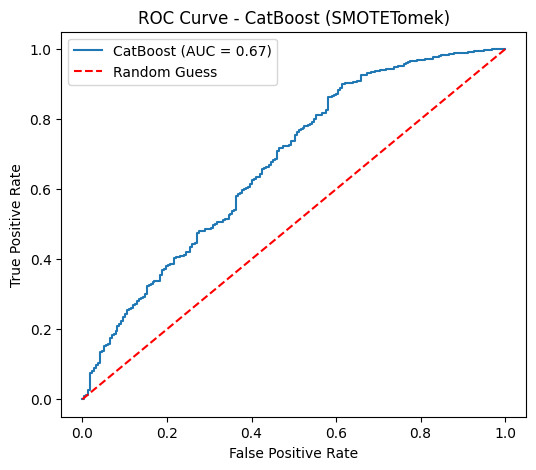

                 Feature  Importance
6           pressure_msl    8.598775
9                   Mins    8.496147
5         wind_speed_10m    8.359166
2                Mission    7.946553
4   relative_humidity_2m    7.866837
3         temperature_2m    7.383746
13       Launch Pad Name    7.044551
1                 Rocket    6.987308
8                     Hr    6.774163
7                   Date    6.244832
16                Season    5.803879
0               Provider    3.939453
10        Year of launch    3.845375
14   Launch Pad Location    3.359415
12                  AmPm    3.178685
15        Launch Country    2.588913
11                Decade    1.582201


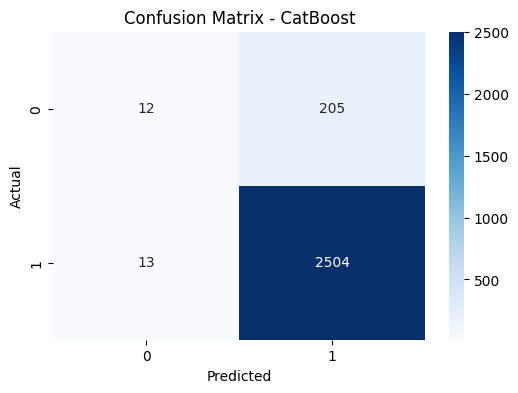

In [ ]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- DATA PREPARATION ---------------- #
X = encoded_data.drop(columns="Status")

# Encode target labels
Y = encoded_data["Status"].astype("category")
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# ---------------- TRAIN/TEST SPLIT ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)
# ---------------- CATBOOST TRAINING ---------------- #
num_classes = len(label_encoder.classes_)
metric = 'Logloss'

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.15,
    depth=10,
    eval_metric=metric,
    random_seed=42,
    verbose=100
)
cat_model.fit(X_train, y_train)

# ---------------- PREDICTIONS ---------------- #
y_pred = cat_model.predict(X_test)
y_pred_proba = cat_model.predict_proba(X_test)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6, 5))
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
else:
    y_test_bin = label_binarize(y_test, classes=range(num_classes))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (SMOTETomek)')
plt.legend()
plt.show()

# ---------------- FEATURE IMPORTANCE ---------------- #
importances = cat_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Cat Normal']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

#CatBoost Over Sampleing (326 3774) to (3774 3774)

Before SMOTETomek Resampling: Counter({np.int64(1): 3774, np.int64(0): 326})
After SMOTETomek Resampling: Counter({np.int64(1): 3693, np.int64(0): 3693})
0:	learn: 0.6105496	total: 28.4ms	remaining: 14.2s
100:	learn: 0.0397216	total: 2.86s	remaining: 11.3s
200:	learn: 0.0123149	total: 5.96s	remaining: 8.86s
300:	learn: 0.0060316	total: 10.1s	remaining: 6.66s
400:	learn: 0.0039530	total: 14.6s	remaining: 3.59s
499:	learn: 0.0034649	total: 18.7s	remaining: 0us
Accuracy: 0.9092904169714704
Confusion Matrix:
 [[  37  180]
 [  68 2449]]
ROC AUC Score: 0.6815003597655757


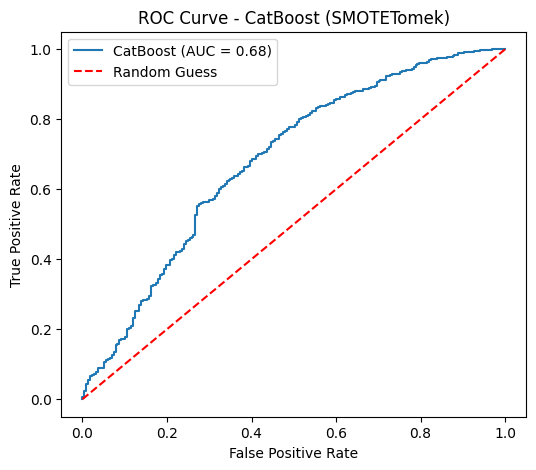

                 Feature  Importance
8                     Hr   11.637883
14   Launch Pad Location   10.473415
2                Mission    6.935413
13       Launch Pad Name    6.873220
15        Launch Country    6.154016
9                   Mins    5.942794
1                 Rocket    5.879429
0               Provider    5.749972
11                Decade    5.321965
4   relative_humidity_2m    5.226898
5         wind_speed_10m    5.028842
12                  AmPm    4.794278
3         temperature_2m    4.756115
6           pressure_msl    4.654540
16                Season    4.059729
10        Year of launch    3.828162
7                   Date    2.683328


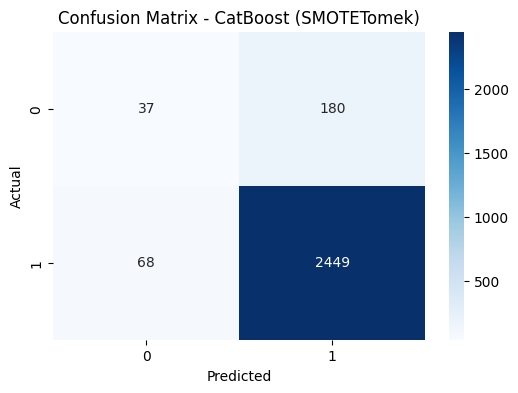

In [9]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- DATA PREPARATION ---------------- #
X = encoded_data.drop(columns="Status")

# Encode target labels
Y = encoded_data["Status"].astype("category")
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# ---------------- TRAIN/TEST SPLIT ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# 🔹 PRINT BEFORE RESAMPLING
print("Before SMOTETomek Resampling:", Counter(y_train))

# ---------------- BALANCING WITH SMOTETomek ---------------- #
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# 🔹 PRINT AFTER RESAMPLING
print("After SMOTETomek Resampling:", Counter(y_res))

# ---------------- CATBOOST TRAINING ---------------- #
num_classes = len(label_encoder.classes_)
metric = 'Logloss'

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.15,
    depth=10,
    eval_metric=metric,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_res, y_res)

# ---------------- PREDICTIONS ---------------- #
y_pred = cat_model.predict(X_test)
y_pred_proba = cat_model.predict_proba(X_test)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6, 5))
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
else:
    y_test_bin = label_binarize(y_test, classes=range(num_classes))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (SMOTETomek)')
plt.legend()
plt.show()

# ---------------- FEATURE IMPORTANCE ---------------- #
importances = cat_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost (SMOTETomek)")
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Cat Over Sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

#CatBoost Under Sampleing (326 3774) to (326 326)|

Original train class distribution: [ 326 3774]
Resampled train class distribution: [326 326]
0:	learn: 0.6396570	total: 23.3ms	remaining: 11.6s
100:	learn: 0.0349089	total: 2.35s	remaining: 9.3s
200:	learn: 0.0132121	total: 4.65s	remaining: 6.92s
300:	learn: 0.0076476	total: 6.72s	remaining: 4.44s
400:	learn: 0.0052664	total: 8.81s	remaining: 2.17s
499:	learn: 0.0040337	total: 10.8s	remaining: 0us
Accuracy: 0.6591075347476225
Confusion Matrix:
 [[ 132   85]
 [ 847 1670]]
ROC AUC Score: 0.6844352412809485


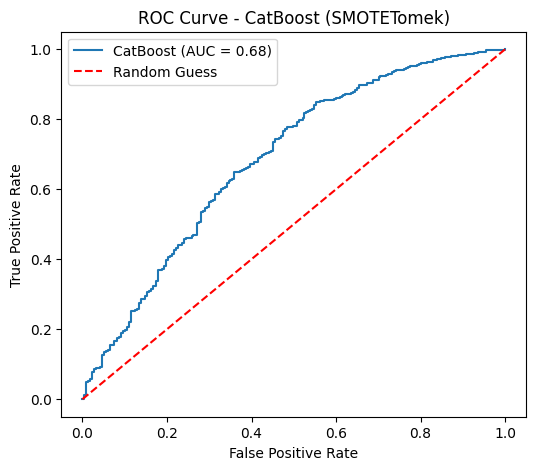

                 Feature  Importance
1                 Rocket    8.836320
9                   Mins    8.332102
3         temperature_2m    8.296525
4   relative_humidity_2m    8.104190
2                Mission    7.403689
5         wind_speed_10m    7.138381
16                Season    6.790728
7                   Date    5.991313
10        Year of launch    5.758801
6           pressure_msl    5.748776
13       Launch Pad Name    5.072675
8                     Hr    5.010657
14   Launch Pad Location    4.243668
11                Decade    3.606574
12                  AmPm    3.594730
15        Launch Country    3.381779
0               Provider    2.689089


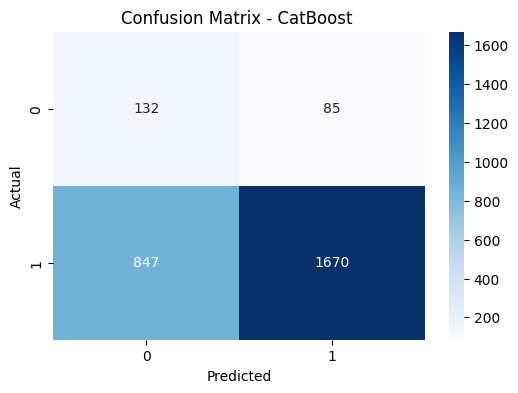

In [10]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Undersample majority class in training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

print("Original train class distribution:", np.bincount(y_train))
print("Resampled train class distribution:", np.bincount(y_train_resampled))

# ---------------- CATBOOST TRAINING ---------------- #
num_classes = len(label_encoder.classes_)
metric = 'Logloss'

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.15,
    depth=10,
    eval_metric=metric,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train_resampled, y_train_resampled)


# ---------------- PREDICTIONS ---------------- #
y_pred = cat_model.predict(X_test_scaled)
y_pred_proba = cat_model.predict_proba(X_test_scaled)


# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6, 5))
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
else:
    y_test_bin = label_binarize(y_test, classes=range(num_classes))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (SMOTETomek)')
plt.legend()
plt.show()

# ---------------- FEATURE IMPORTANCE ---------------- #
importances = cat_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost ")
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Cat Undersample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}


______________________________________________________________________________________________________________________________

#Nural Network Keras

c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9082 - loss: 0.1040 - val_accuracy: 0.8976 - val_loss: 0.1189
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9165 - loss: 0.0876 - val_accuracy: 0.9085 - val_loss: 0.1006
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9177 - loss: 0.0866 - val_accuracy: 0.9098 - val_loss: 0.0934
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9177 - loss: 0.0852 - val_accuracy: 0.9098 - val_loss: 0.0968
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9210 - loss: 0.0837 - val_accuracy: 0.9098 - val_loss: 0.0913
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9210 - loss: 0.0817 - val_accuracy: 0.9098 - val_loss: 0.0917
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9201 - loss: 0.0790 - val_accuracy: 0.9098 - val_loss: 0.0898
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9213 - loss: 0.0819 - val_accuracy: 0.9098 - val_loss

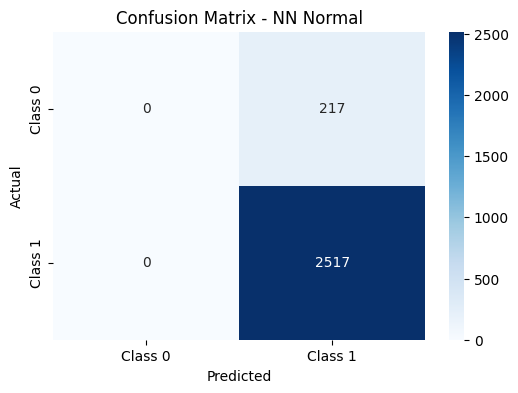


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       217
           1       0.92      1.00      0.96      2517

    accuracy                           0.92      2734
   macro avg       0.46      0.50      0.48      2734
weighted avg       0.85      0.92      0.88      2734

Accuracy: 0.9206
Precision: 0.9206
Recall: 1.0000
F1 Score: 0.9587
ROC AUC Score: 0.5581


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [11]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, roc_auc_score, precision_score, recall_score
)
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

model = keras.Sequential([
     keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

     keras.layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

     keras.layers.Dense(16, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
loss_fn = BinaryFocalCrossentropy(gamma=2.0)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    epochs=30, batch_size=64,
    validation_split=0.2,
    verbose=1
)

y_pred_probs = model.predict(X_test).ravel() 
y_pred = (y_pred_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NN Normal")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Results['NN normal'] = {
    "acc": acc,
    "Confusion Matrix": str(cm),
    "ROC AUC Score": roc_auc,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


#NN Undersampled from (326 3774) to (326 326)

Original train class distribution: [ 326 3774]
Resampled train class distribution: [326 326]
Epoch 1/50


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6104 - loss: 0.2446 - val_accuracy: 0.0534 - val_loss: 0.2493
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6276 - loss: 0.2020 - val_accuracy: 0.2519 - val_loss: 0.2096
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6238 - loss: 0.1903 - val_accuracy: 0.4198 - val_loss: 0.1869
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6027 - loss: 0.1771 - val_accuracy: 0.5267 - val_loss: 0.1771
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6334 - loss: 0.1741 - val_accuracy: 0.4733 - val_loss: 0.1762
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6641 - loss: 0.1570 - val_accuracy: 0.4809 - val_loss: 0.1774
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6775 - loss: 0.1547 - val_accuracy: 0.5191 - val_loss: 0.1764
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6372 - loss: 0.1571 - val_accuracy: 0.4962 - val_loss: 0.1768


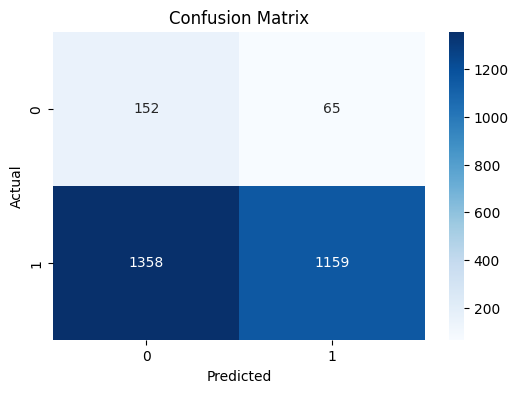


Results Dictionary:
 {'Cat Normal': {'acc': 0.9202633504023409, 'Confusion Matrix': '[[  12  205]\n [  13 2504]]', 'ROC AUC Score': 0.6739754920000219, 'precision': 0.8890597463871139, 'recall': 0.9202633504023409, 'f1': 0.8900970203290152}, 'Cat Over Sample': {'acc': 0.9092904169714704, 'Confusion Matrix': '[[  37  180]\n [  68 2449]]', 'ROC AUC Score': 0.6815003597655757, 'precision': 0.885565099347226, 'recall': 0.9092904169714704, 'f1': 0.8945019606430556}, 'Cat Undersample': {'acc': 0.6591075347476225, 'Confusion Matrix': '[[ 132   85]\n [ 847 1670]]', 'ROC AUC Score': 0.6844352412809485, 'precision': 0.8867419327214006, 'recall': 0.6591075347476225, 'f1': 0.7373002483668565}, 'NN normal': {'acc': 0.9206291148500366, 'Confusion Matrix': '[[   0  217]\n [   0 2517]]', 'ROC AUC Score': 0.5580925284104953, 'precision': 0.9206291148500366, 'recall': 1.0, 'f1': 0.9586745381832033}, 'NN Undersampled': {'acc': 0.4795171909290417, 'Confusion Matrix': '[[ 152   65]\n [1358 1159]]', 'ROC A

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, roc_auc_score, precision_score, recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from tensorflow import keras
from keras import layers
from keras.losses import BinaryFocalCrossentropy

# Prepare features and target
X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Undersample majority class in training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

print("Original train class distribution:", np.bincount(y_train))
print("Resampled train class distribution:", np.bincount(y_train_resampled))

# Build model
model = keras.Sequential([
     layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

     layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

     layers.Dense(16, activation='relu'),
     layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
loss_fn = BinaryFocalCrossentropy(gamma=2.0)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

# Train model on undersampled data
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predict probabilities on test set
y_pred_probs = model.predict(X_test_scaled).ravel()  # flatten for metrics
threshold = 0.5
y_pred_classes = (y_pred_probs > threshold).astype(int)

# Confusion matrix and metrics
cm = confusion_matrix(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Display metrics
print("\nAccuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()

# Store results
Results['NN Undersampled'] = {
    "acc": accuracy,
    "Confusion Matrix": str(cm),
    "ROC AUC Score": roc_auc,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

print("\nResults Dictionary:\n", Results)


#NN OverSampled minority from(326 3774) to (3774 3774)

Resampled class distribution: [3774 3774]
Epoch 1/50


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5922 - loss: 0.1967 - val_accuracy: 0.4887 - val_loss: 0.1920
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6343 - loss: 0.1658 - val_accuracy: 0.6305 - val_loss: 0.1681
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6618 - loss: 0.1554 - val_accuracy: 0.6762 - val_loss: 0.1593
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6837 - loss: 0.1510 - val_accuracy: 0.7126 - val_loss: 0.1494
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6943 - loss: 0.1469 - val_accuracy: 0.6232 - val_loss: 0.1653
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7064 - loss: 0.1442 - val_accuracy: 0.7199 - val_loss: 0.1438
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7092 - loss: 0.1407 - val_accuracy: 0.6815 - val_loss: 0.1518
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7266 - loss: 0.1370 - val_accuracy: 0.7238 - val_

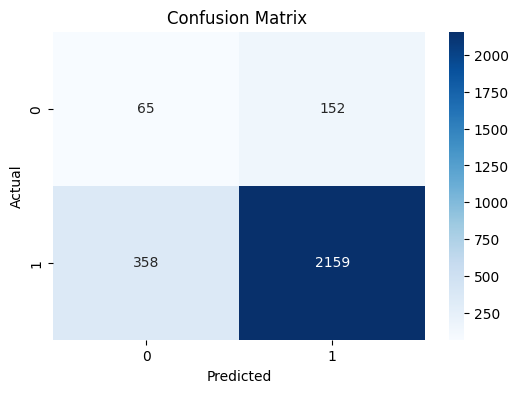

                      acc             Confusion Matrix  ROC AUC Score  \
Cat Normal       0.920263  [[  12  205]\n [  13 2504]]       0.673975   
Cat Over Sample  0.909290  [[  37  180]\n [  68 2449]]       0.681500   
Cat Undersample  0.659108  [[ 132   85]\n [ 847 1670]]       0.684435   
NN normal        0.920629  [[   0  217]\n [   0 2517]]       0.558093   
NN Undersampled  0.479517  [[ 152   65]\n [1358 1159]]       0.646181   
NN Oversampled   0.813460  [[  65  152]\n [ 358 2159]]       0.627796   

                 precision    recall        f1  
Cat Normal        0.889060  0.920263  0.890097  
Cat Over Sample   0.885565  0.909290  0.894502  
Cat Undersample   0.886742  0.659108  0.737300  
NN normal         0.920629  1.000000  0.958675  
NN Undersampled   0.946895  0.460469  0.619620  
NN Oversampled    0.934228  0.857767  0.894366  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

from tensorflow import keras
from keras import layers
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.layers import BatchNormalization, Dropout

X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]


label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)


X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


smt = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_scaled, y_train)
print("Resampled class distribution:", np.bincount(y_train_resampled))


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(enumerate(class_weights))


model = keras.Sequential([
    layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    layers.Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
loss_fn = BinaryFocalCrossentropy(gamma=2.0)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])


history = model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    class_weight=class_weight_dict
)


y_pred_probs = model.predict(X_test_scaled)
threshold = 0.5
y_pred_classes = (y_pred_probs > threshold).astype(int)


accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, zero_division=0)
recall = recall_score(y_test, y_pred_classes, zero_division=0)
f1 = f1_score(y_test, y_pred_classes, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_probs)
cm = confusion_matrix(y_test, y_pred_classes)


print(f"\nOverall Evaluation at Threshold = {threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

Results['NN Oversampled'] = {
    "acc": accuracy,
    "Confusion Matrix": str(cm),
    "ROC AUC Score": roc_auc,
    "precision": precision,
    "recall": recall,
    "f1": f1
}



results_df = pd.DataFrame.from_dict(Results, orient='index')
print(results_df)


______________________________________________________________________________________________________________________________

#Random forest Normal

Accuracy: 0.9213606437454279
Confusion Matrix:
 [[  12  205]
 [  10 2507]]
ROC AUC Score: 0.726644989188724


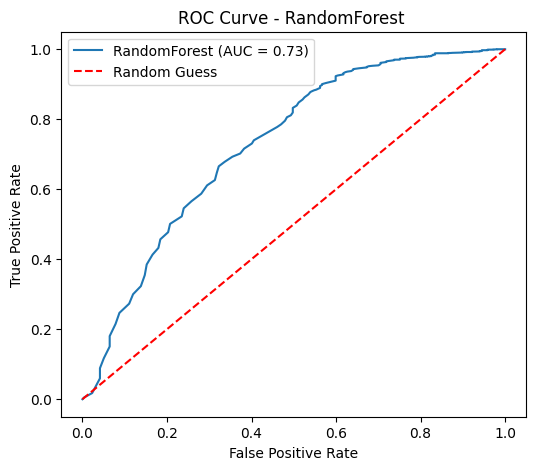

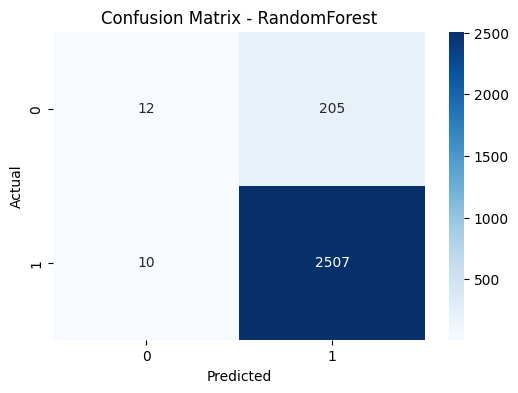

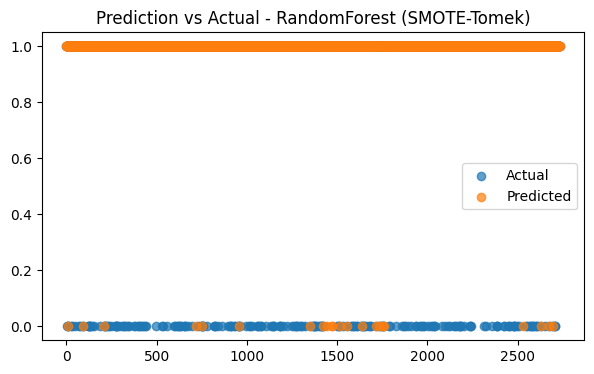

C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\889294244.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Categorical.from_codes(y_pred, classes), palette="Set2")


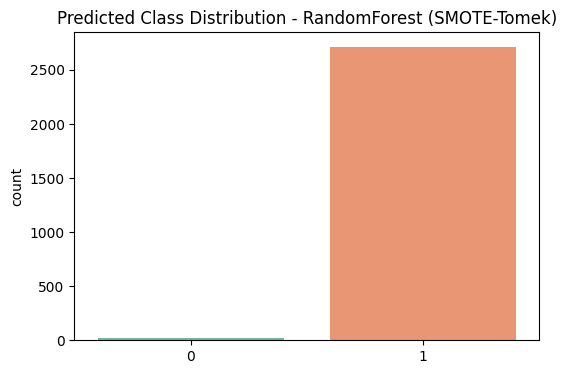

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- DATA SPLIT ---------------- #
X = encoded_data.drop(['Status'], axis=1)

# Convert categorical to codes for training (needed for SMOTE)
Y = encoded_data['Status'].astype('category')
Y_encoded = Y.cat.codes  # numeric labels for model
classes = Y.cat.categories
n_classes = len(classes)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y_encoded,
    test_size=0.4,
    random_state=42,
    stratify=Y_encoded
)
# ---------------- MODEL TRAINING ---------------- #
model = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)

# ---------------- EVALUATION ---------------- #
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6,5))

if n_classes == 2:
    # Binary ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc:.2f})')
else:
    # Multiclass ROC
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest ')
plt.legend()
plt.show()

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)3
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest")
plt.show()

# ---------------- ACTUAL vs PREDICTED SCATTER ---------------- #
plt.figure(figsize=(7,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - RandomForest (SMOTE-Tomek)")
plt.legend()
plt.show()

# ---------------- PREDICTED CLASS DISTRIBUTION ---------------- #
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Categorical.from_codes(y_pred, classes), palette="Set2")
plt.title("Predicted Class Distribution - RandomForest (SMOTE-Tomek)")
plt.show()


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Random forest normal']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}


#Random Forest oversampled

Resampled class distribution: [3693 3693]


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ROC AUC Score: 0.4174800298065322
Accuracy: 0.24798829553767374
Confusion Matrix:
 [[ 151   66]
 [1990  527]]


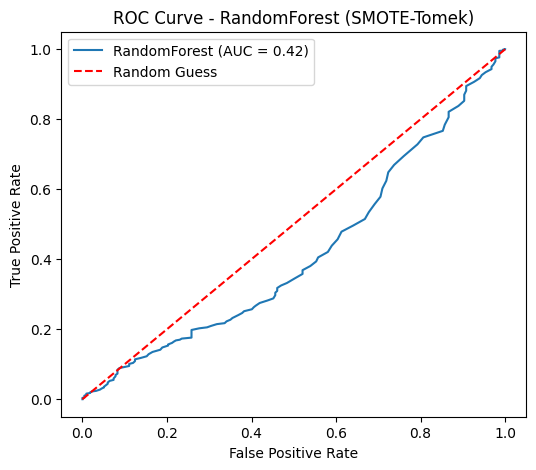

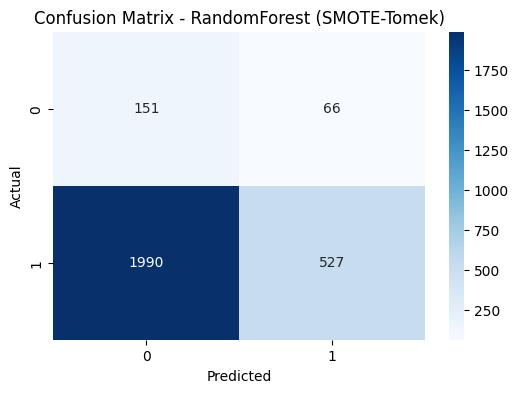

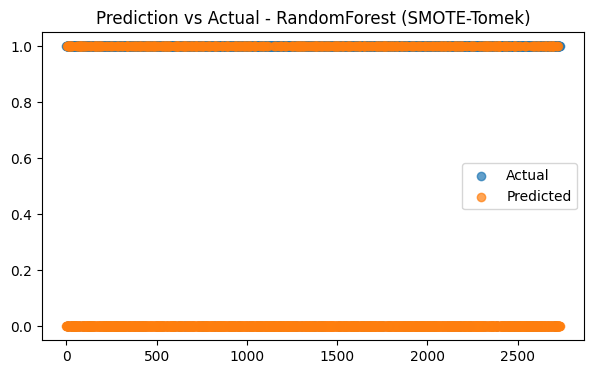

C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\1167574510.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Categorical.from_codes(y_pred, classes), palette="Set2")


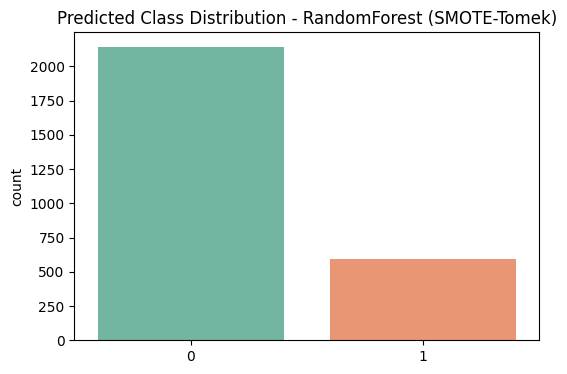

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- DATA SPLIT ---------------- #
X = encoded_data.drop(['Status'], axis=1)

# Convert categorical to codes for training (needed for SMOTE)
Y = encoded_data['Status'].astype('category')
Y_encoded = Y.cat.codes  # numeric labels for model
classes = Y.cat.categories
n_classes = len(classes)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y_encoded,
    test_size=0.4,
    random_state=42,
    stratify=Y_encoded
)

# ---------------- RESAMPLING ---------------- #

smt = SMOTETomek(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)
print("Resampled class distribution:", np.bincount(y_train_resampled))

# ---------------- MODEL TRAINING ---------------- #
model = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)

# ---------------- EVALUATION ---------------- #
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)


# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6,5))

if n_classes == 2:
    # Binary ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc:.2f})')
else:
    # Multiclass ROC
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest (SMOTE-Tomek)')
plt.legend()
plt.show()

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest (SMOTE-Tomek)")
plt.show()

# ---------------- ACTUAL vs PREDICTED SCATTER ---------------- #
plt.figure(figsize=(7,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - RandomForest (SMOTE-Tomek)")
plt.legend()
plt.show()

# ---------------- PREDICTED CLASS DISTRIBUTION ---------------- #
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Categorical.from_codes(y_pred, classes), palette="Set2")
plt.title("Predicted Class Distribution - RandomForest (SMOTE-Tomek)")
plt.show()
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Random forest Over sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}


#Random Forest Under sampled

before Counter({np.int64(1): 5031, np.int64(0): 436})
before Counter({np.int64(0): 436, np.int64(1): 436})
Accuracy: 0.7022677395757132
ROC AUC Score: 0.713977896454532


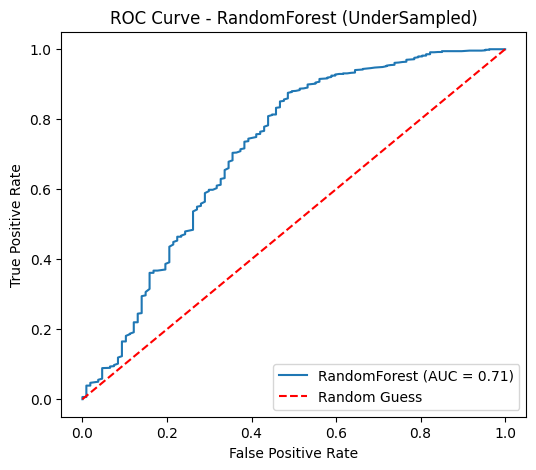

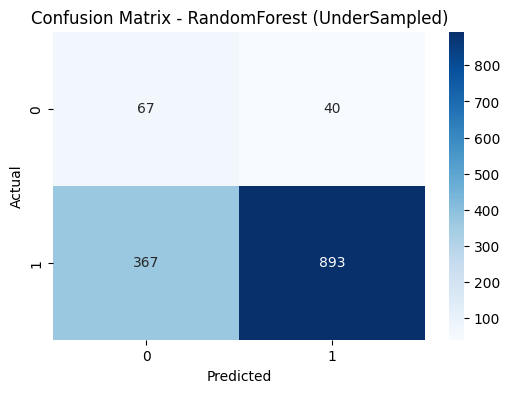

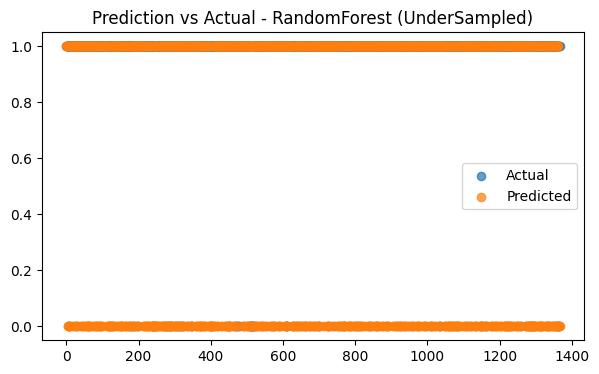

C:\Users\Nagasheshu\AppData\Local\Temp\ipykernel_7976\444756318.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_encoder.inverse_transform(y_pred), palette="Set2")


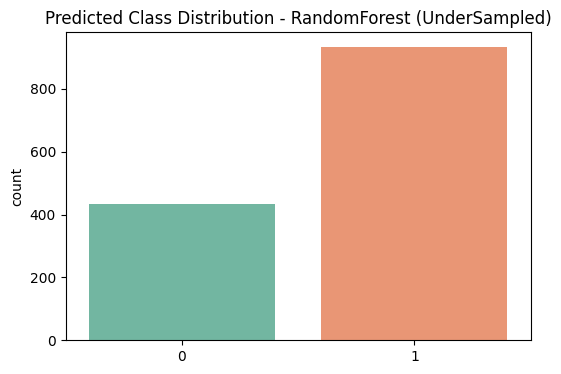

In [ ]:

# ---------------- DATA PREP ---------------- #
X = encoded_data.drop("Status", axis=1)
Y = encoded_data["Status"].astype("category")

# Encode target labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42
)


# ---------------- BALANCING WITH UNDERSAMPLING ---------------- #
print("before",Counter(y_train))
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X_train, y_train)
print("after",Counter(y_res))


# ---------------- MODEL TRAINING ---------------- #
model = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42
)
model.fit(X_res, y_res)

# ---------------- EVALUATION ---------------- #
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save score
Trained_models = {}
Trained_models["RandomForestClassifier"] = accuracy

# ---------------- ROC CURVE ---------------- #
plt.figure(figsize=(6,5))

if len(label_encoder.classes_) == 2:
    # Binary classification ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print("ROC AUC Score:", roc_auc)
    plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc:.2f})')
else:
    # Multiclass ROC
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest (UnderSampled)')
plt.legend()
plt.show()

# ---------------- FORECASTING ---------------- #
# encoded_forecasting_data = encoder.transform(data_forcasting[categorical_cols])
# y_pred_forecast = model.predict(encoded_forecasting_data)

# # Attach predictions back (decode labels)
# result = data_forcasting.copy()
# result["Predicted_Status"] = label_encoder.inverse_transform(y_pred_forecast)


# ---------------- GRAPHS ---------------- #
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest (UnderSampled)")
plt.show()

# Actual vs Predicted (scatter plot)
plt.figure(figsize=(7,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - RandomForest (UnderSampled)")
plt.legend()
plt.show()

# Predicted class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=label_encoder.inverse_transform(y_pred), palette="Set2")
plt.title("Predicted Class Distribution - RandomForest (UnderSampled)")
plt.show()
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Random forest under sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

______________________________________________________________________________________________________________________________

#logistic

Accuracy: 0.9206291148500366
ROC AUC Score: 0.6450972099401489
Confusion Matrix:
 [[   0  217]
 [   0 2517]]


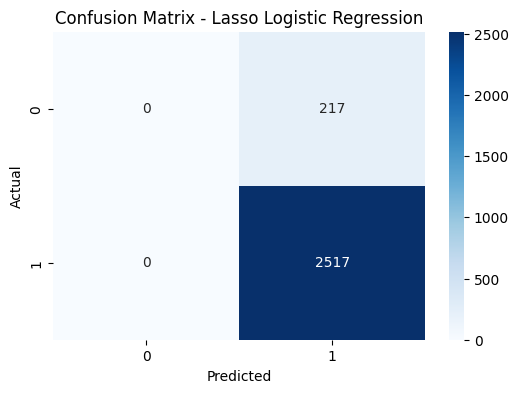

c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
from sklearn.linear_model import LogisticRegression
# 1️⃣ Prepare features and target
X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

# Encode target
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# ---------------- LOGISTIC REGRESSION ---------------- #
logistic_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0, 
    max_iter=1000,
    random_state=42
)

logistic_model.fit(X_train, y_train)

# ---------------- PREDICTIONS ---------------- #
y_pred = lasso_model.predict(X_test)
y_pred_proba = lasso_model.predict_proba(X_test)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Lasso Logistic Regression")
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Logistic normal']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}


#logistic over sampled

Before SMOTETomek Resampling: Counter({np.int64(1): 3774, np.int64(0): 326})
After SMOTETomek Resampling: Counter({np.int64(1): 3771, np.int64(0): 3771})
Accuracy: 0.6514264813460132
ROC AUC Score: 0.6511299202290781
Confusion Matrix:
 [[ 125   92]
 [ 861 1656]]


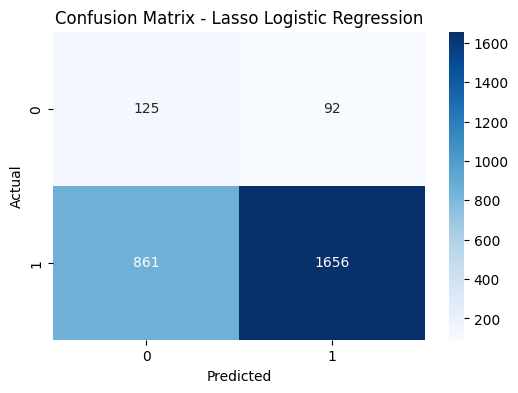

In [18]:
from sklearn.linear_model import LogisticRegression
# 1️⃣ Prepare features and target
X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

# Encode target
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# 3️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Before SMOTETomek Resampling:", Counter(y_train))

smote = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTETomek Resampling:", Counter(y_train_resampled))

# ---------------- LASSO LOGISTIC REGRESSION ---------------- #
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,  # Regularization strength (lower = stronger regularization)
    max_iter=1000,
    random_state=42
)

lasso_model.fit(X_train_resampled, y_train_resampled)

# ---------------- PREDICTIONS ---------------- #
y_pred = lasso_model.predict(X_test_scaled)
y_pred_proba = lasso_model.predict_proba(X_test_scaled)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Lasso Logistic Regression")
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Logistic over sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

#Logistic under sampled

Before SMOTETomek Resampling: Counter({np.int64(1): 3774, np.int64(0): 326})
After SMOTETomek Resampling: Counter({np.int64(0): 326, np.int64(1): 326})
Accuracy: 0.5731528895391368
ROC AUC Score: 0.6091279758471884
Confusion Matrix:
 [[ 128   89]
 [1078 1439]]


c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Nagasheshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


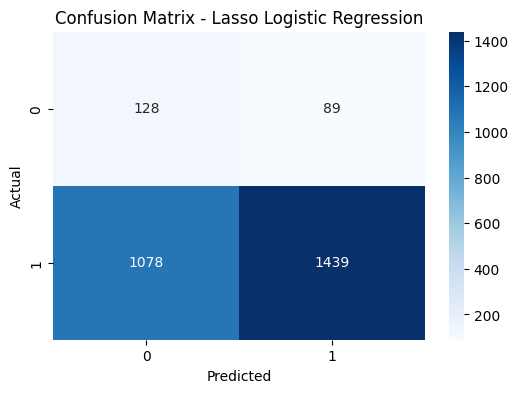

In [19]:
from sklearn.linear_model import LogisticRegression

X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

# Encode target
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
print("Before SMOTETomek Resampling:", Counter(y_train))
# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# 3️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Resample with SMOTE-Tomek
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X_train, y_train)

print("After SMOTETomek Resampling:", Counter(y_res))
# ---------------- LASSO LOGISTIC REGRESSION ---------------- #
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,  # Regularization strength (lower = stronger regularization)
    max_iter=1000,
    random_state=42
)

lasso_model.fit(X_res, y_res)

# ---------------- PREDICTIONS ---------------- #
y_pred = lasso_model.predict(X_test_scaled)
y_pred_proba = lasso_model.predict_proba(X_test_scaled)

# ---------------- EVALUATION ---------------- #
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------- CONFUSION MATRIX HEATMAP ---------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Lasso Logistic Regression")
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['Logistic Under sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

______________________________________________________________________________________________________________________________

#SVC

Accuracy: 0.44111192392099485
Confusion Matrix:
 [[ 65  44]
 [720 538]]
Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.60      0.15       109
           1       0.92      0.43      0.58      1258

    accuracy                           0.44      1367
   macro avg       0.50      0.51      0.37      1367
weighted avg       0.86      0.44      0.55      1367

ROC AUC Score: 0.5463966394889223


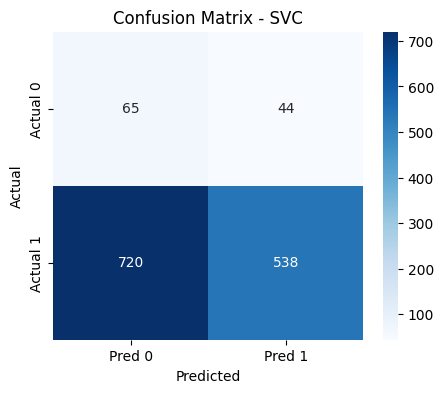

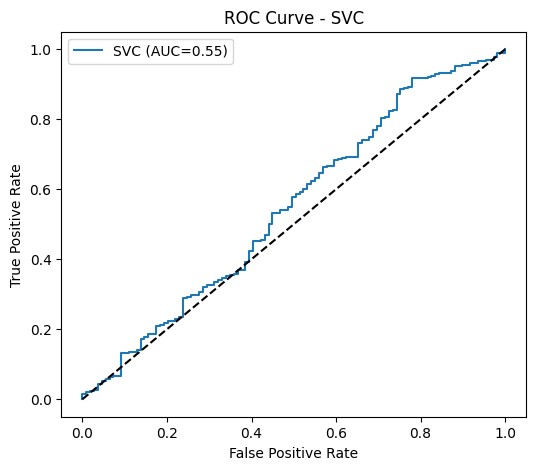

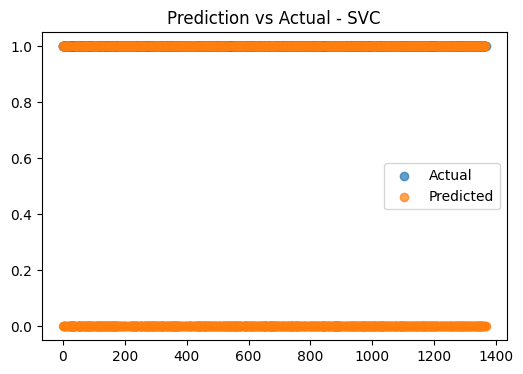

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
X = encoded_data.drop("Status", axis=1)
Y = encoded_data["Status"].astype("category")


# ---------------- TRAIN/TEST SPLIT ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y_encoded
)
model = SVC(class_weight='balanced', probability=True, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # needed for ROC

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# --- PLOTS ---
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix - SVC")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVC (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVC")
plt.legend()
plt.show()

# 3. Prediction vs Actual
plt.figure(figsize=(6,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - SVC")
plt.legend()
plt.show()
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['SVC normal']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}


#SVC Oversampled


Before SMOTETomek Resampling: Counter({1: 5033, 0: 434})
After SMOTETomek Resampling: Counter({1: 5033, 0: 5033})
Accuracy: 0.4520848573518654
Confusion Matrix:
 [[ 65  44]
 [705 553]]
Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.60      0.15       109
           1       0.93      0.44      0.60      1258

    accuracy                           0.45      1367
   macro avg       0.51      0.52      0.37      1367
weighted avg       0.86      0.45      0.56      1367

ROC AUC Score: 0.547381164218725


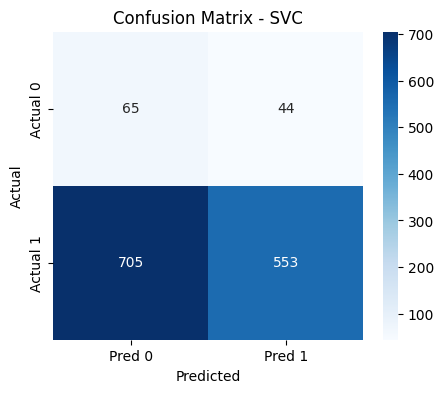

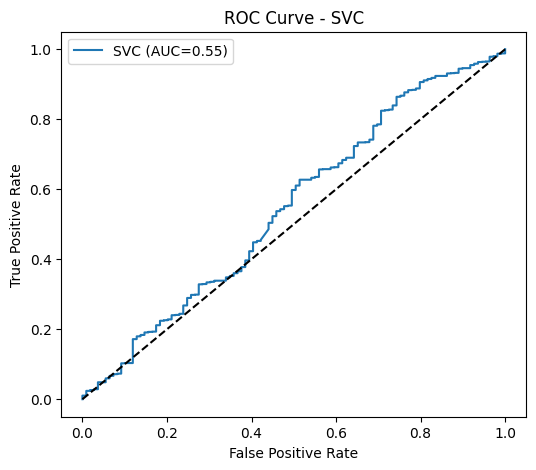

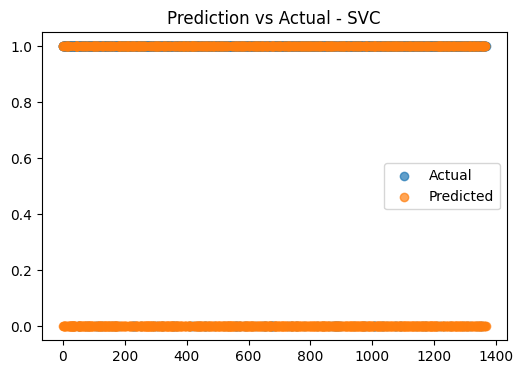

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
X = encoded_data.drop("Status", axis=1)
Y = encoded_data["Status"].astype("category")


# ---------------- TRAIN/TEST SPLIT ---------------- #
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y_encoded
)
print("Before SMOTETomek Resampling:", Counter(y_train))
# ---------------- BALANCING WITH SMOTE ---------------- #
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("After SMOTETomek Resampling:", Counter(y_res))
# Train SVC model
model = SVC(class_weight='balanced', probability=True, random_state=42)
model.fit(X_res, y_res)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # needed for ROC

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# --- PLOTS ---
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix - SVC")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVC (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVC")
plt.legend()
plt.show()

# 3. Prediction vs Actual
plt.figure(figsize=(6,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - SVC")
plt.legend()
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['SVC Over sample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

#SVC UNDER SAMPLED

Before SMOTETomek Resampling: Counter({1: 5033, 0: 434})
After SMOTETomek Resampling: Counter({np.int64(0): 326, np.int64(1): 326})
Accuracy: 0.4685442574981712
Confusion Matrix:
 [[ 138   79]
 [1374 1143]]
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.64      0.16       217
           1       0.94      0.45      0.61      2517

    accuracy                           0.47      2734
   macro avg       0.51      0.55      0.39      2734
weighted avg       0.87      0.47      0.58      2734

ROC AUC Score: 0.5570013310410865


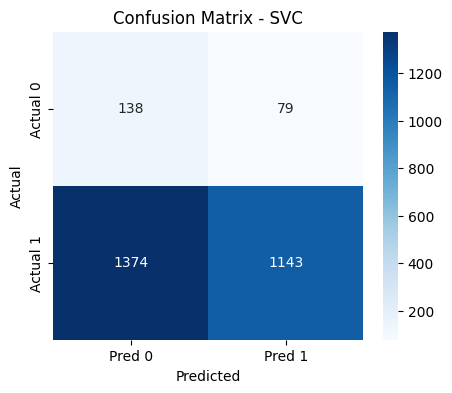

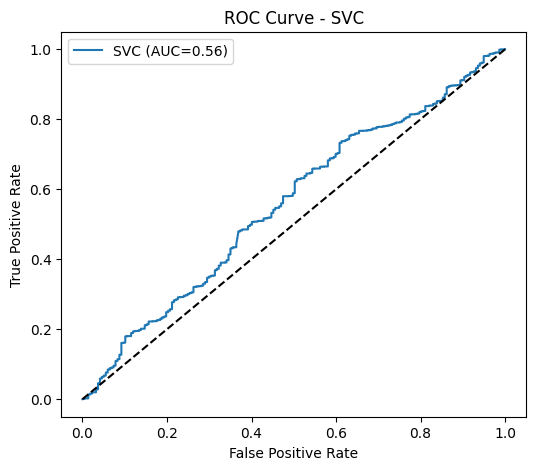

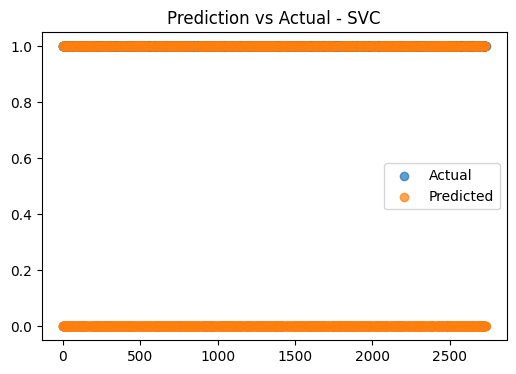

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
# 1️⃣ Prepare features and target
X = encoded_data.drop(columns="Status")
Y = encoded_data["Status"]

# Encode target
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
print("Before SMOTETomek Resampling:", Counter(y_train))
# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.4, random_state=42, stratify=Y_encoded
)

# 3️⃣ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Resample with SMOTE-Tomek
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X_train, y_train)

print("After SMOTETomek Resampling:", Counter(y_res))
# Train SVC model
model = SVC(class_weight='balanced', probability=True, random_state=42)
model.fit(X_res, y_res)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # needed for ROC

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# --- PLOTS ---
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix - SVC")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVC (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVC")
plt.legend()
plt.show()

# 3. Prediction vs Actual
plt.figure(figsize=(6,4))
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7)
plt.title("Prediction vs Actual - SVC")
plt.legend()
plt.show()

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

Results['SVC Undersample']={"acc":accuracy,"Confusion Matrix":str( confusion_matrix(y_test, y_pred)),"ROC AUC Score":roc_auc,"precision":precision,"recall":recall,"f1":f1}

______________________________________________________________________________________________________________________________

In [23]:
Results

{'Cat Normal': {'acc': 0.9202633504023409,
  'Confusion Matrix': '[[  12  205]\n [  13 2504]]',
  'ROC AUC Score': 0.6739754920000219,
  'precision': 0.8890597463871139,
  'recall': 0.9202633504023409,
  'f1': 0.8900970203290152},
 'Cat Over Sample': {'acc': 0.9092904169714704,
  'Confusion Matrix': '[[  37  180]\n [  68 2449]]',
  'ROC AUC Score': 0.6815003597655757,
  'precision': 0.885565099347226,
  'recall': 0.9092904169714704,
  'f1': 0.8945019606430556},
 'Cat Undersample': {'acc': 0.6591075347476225,
  'Confusion Matrix': '[[ 132   85]\n [ 847 1670]]',
  'ROC AUC Score': 0.6844352412809485,
  'precision': 0.8867419327214006,
  'recall': 0.6591075347476225,
  'f1': 0.7373002483668565},
 'NN normal': {'acc': 0.9206291148500366,
  'Confusion Matrix': '[[   0  217]\n [   0 2517]]',
  'ROC AUC Score': 0.5580925284104953,
  'precision': 0.9206291148500366,
  'recall': 1.0,
  'f1': 0.9586745381832033},
 'NN Undersampled': {'acc': 0.4795171909290417,
  'Confusion Matrix': '[[ 152   65]

<Figure size 1000x600 with 0 Axes>

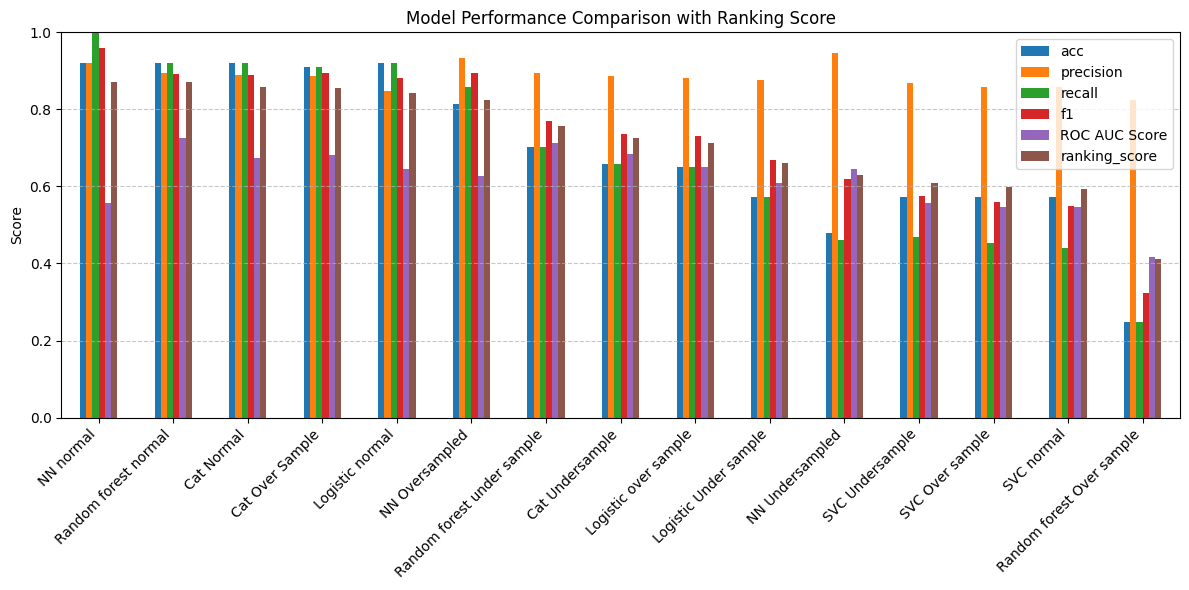

,acc,precision,recall,f1,ROC AUC Score,ranking_score
NN normal,0.9206,0.9206,1.0000,0.9587,0.5581,0.8716
Random forest normal,0.9214,0.8943,0.9214,0.8907,0.7266,0.8709
Cat Normal,0.9203,0.8891,0.9203,0.8901,0.6740,0.8587
Cat Over Sample,0.9093,0.8856,0.9093,0.8945,0.6815,0.8560
Logistic normal,0.9206,0.8476,0.9206,0.8826,0.6451,0.8433
NN Oversampled,0.8135,0.9342,0.8578,0.8944,0.6278,0.8255
Random forest under sample,0.7023,0.8943,0.7023,0.7701,0.7140,0.7566
Cat Undersample,0.6591,0.8867,0.6591,0.7373,0.6844,0.7253
Logistic over sample,0.6514,0.8822,0.6514,0.7314,0.6511,0.7135
Logistic Under sample,0.5732,0.8754,0.5732,0.6693,0.6091,0.6600


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results dict to DataFrame
df_results = pd.DataFrame(Results).T  # transpose to have models as rows

# Select numeric metrics for comparison
metrics = ["acc", "precision", "recall", "f1", "ROC AUC Score"]
df_metrics = df_results[metrics].astype(float)

# # ✅ Add custom ranking score
# df_metrics["ranking_score"] = (
#     0.5 * df_metrics["f1"] +
#     0.3 * df_metrics["ROC AUC Score"] +
#     0.2 * df_metrics["recall"]
# )
df_metrics["ranking_score"] = (
    0.2 * df_metrics["f1"] +
     0.2 * df_metrics["precision"] +
      0.2 * df_metrics["acc"] +
    0.2 * df_metrics["ROC AUC Score"] +
    0.2 * df_metrics["recall"]
)

# Sort by ranking score
df_metrics_sorted = df_metrics.sort_values(by="ranking_score", ascending=False)

# Display nicely


# 📊 Plot comparison
plt.figure(figsize=(10, 6))
df_metrics_sorted[["acc", "precision", "recall", "f1", "ROC AUC Score", "ranking_score"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison with Ranking Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
df_metrics_sorted.round(4)